In [2]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

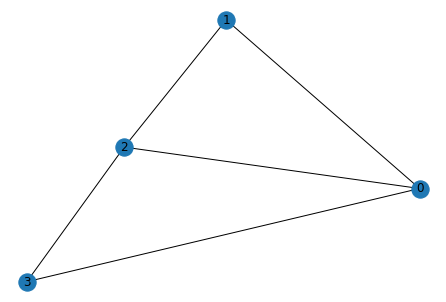

In [3]:
n_nodes = 4 # n_wires = n_nodes
nodes = range(n_nodes)
edges = [(0,1,0.5),(1,2,2),(2,0,1.5), (2,3,1.7), (0,3,0.5)] # input the edges here. 3rd element of each tuple is the weight.
graph = nx.Graph() 
graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges)
nx.draw(graph, with_labels=True)
plt.show()

In [4]:
def U_B(beta):
    for edge in edges:
        qml.RX(2 * beta, wires=edge[1])

def U_C(gamma):
    for edge in edges:
        qml.CNOT(wires=[edge[0], edge[1]])
        qml.RZ(gamma, wires=edge[1])
        qml.CNOT(wires=[edge[0], edge[1]])

In [5]:
def measure_computational_basis(wires):
    n_wires = n_nodes
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [6]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device('default.qubit', wires=n_nodes, shots=1) # here the parameter/attribute "wires" means n_wires
@qml.qnode(dev)
def circuit(betas, gammas, edge=None, n_layers=1):
    for i in range(n_nodes):
        qml.Hadamard(wires=i) # Apply Hadamard to each node, to initialize in state |E>. here "wires" means wire_number (ordinal number)
    for i in range(n_layers): # Apply U_B and U_C n_layers number of times
        U_C(gammas[i])
        U_B(betas[i]) # betas [i] because ith element in the betas array, there will be n_layers amount of parameters in array beta, one for each layer.
        

    if edge is None: # what is "is" keyword? old: if edge == None
        # print(f'1: {qml.sample(Hermitian(pauli_z_2, wires=edge))}')
        
        bitstring = qml.sample(measure_computational_basis(range(n_nodes))) # what is qml.sample? docs. old: wires = range(n_nodes)
        # print(x)
        return bitstring

    # expval = qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]]))
    # print(expval)
    # return expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0], edge[1]]))

In [17]:
def qaoa_maxcut(n_layers):
    initial_params = 0.1*np.random.rand(2, n_layers) 
    print(initial_params)

    def neg_objective(params):
        objective = 0
        for edge in edges:
            objective += 0.5 * (1- circuit(params[0], params[1], edge=edge, n_layers=n_layers)) * edge[2] # if expval prints out some bullshit, then why does objective get to take in the circuit output like an int?
            # take the current objective (non maxcut objective) and multiply by the weight
            # wait is this an edge being cut or an edge being kept? i think it's edge being cut bc we were trying to maximize objective.
            # print(objective)
        return -objective
    
    opt = qml.GradientDescentOptimizer(stepsize=0.04)
    params = initial_params
    n_steps = 100
    for i in range(n_steps):
        params = opt.step(neg_objective, params)
        if i % 5 == 0:
            print(f'Step: {i} | Objective: {- neg_objective(params)}')
    print(f'Optimal params: {params}')

    shots = 100
    bit_strings = []
    for i in range(shots):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers))) # added int

    # find most common bitstring
    # counts = np.bincount(np.array(bit_strings))
    # most_freq_bit_string = np.argmax(counts)
    # print("most frequently sampled bitstring is " + most_freq_bit_string) 
    return params, bit_strings

In [23]:
# bitstrings1 = qaoa_maxcut(n_layers=1)[1]
# bitstrings2 = qaoa_maxcut(n_layers=2)[1]
bitstrings3 = qaoa_maxcut(n_layers=3)[1]
bitstrings4 = qaoa_maxcut(n_layers=4)[1]
# oh wait objective is supposed to be the NUMBER OF CUT EDGES

[[0.0372174  0.08142796 0.03776266]
 [0.04405342 0.06550495 0.05173719]]
Step: 0 | Objective: 3.1197580621225405
Step: 5 | Objective: 3.869208194027805
Step: 10 | Objective: 3.954030595396277
Step: 15 | Objective: 3.6746728927542334
Step: 20 | Objective: 3.9277584643918755
Step: 25 | Objective: 3.980784059350076
Step: 30 | Objective: 4.030430810876263
Step: 35 | Objective: 4.027656532738794
Step: 40 | Objective: 4.060897900382903
Step: 45 | Objective: 4.05189306749321
Step: 50 | Objective: 4.090671727684006
Step: 55 | Objective: 4.080322572730214
Step: 60 | Objective: 4.115968891660724
Step: 65 | Objective: 4.106123063722434
Step: 70 | Objective: 4.133797977950776
Step: 75 | Objective: 4.125683992226308
Step: 80 | Objective: 4.145946486252916
Step: 85 | Objective: 4.139688336638631
Step: 90 | Objective: 4.154635934838399
Step: 95 | Objective: 4.149871205259038
Optimal params: [[ 0.33949907  0.27641792 -0.14368689]
 [-0.52447244 -0.60835885  0.36285139]]
[[0.02324791 0.03639945 0.063524

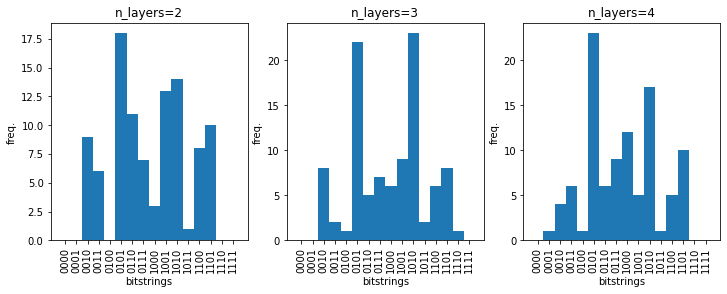

In [24]:
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) # 12 is x width, once changing from 8 -> 12 the plot looks much nicely spaced. less crammed.

plt.subplot(1, 3, 1)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)

plt.subplot(1, 3, 2)
plt.title("n_layers=3")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings3, bins=bins)

plt.subplot(1, 3, 3)
plt.title("n_layers=4")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings4, bins=bins)

plt.show()

In [ ]:
# error: circuit was wrong, put U_B before U_C

# it's not the right answer!!!! with n_layers = 2, the answer is 1110 and 0001.

# problem right now: circuit has zero bugs (bugs as in errors and syntaxtypeerrors that cuase the program to end earlier than wanted finish with signal -1), but it does not give the correct answer.